# TASS Exploratory Analysis

The dataset for this analysis was obtained via the TASS page : http://tass.sepln.org/tass_data/download.php

In [1]:
# Libraries for this project
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from wordcloud import WordCloud
import num2words
import seaborn as sns
import numpy as np
from nltk.stem import SnowballStemmer
import pickle
import spacy
import spacy_spanish_lemmatizer

The datasets are in xml format. The first thing to do is to convert the xml into a pandas dataset and concatenate them insto a master datarame.

In [2]:
def xmltodf(file):
    # Conversion of the xml file into a tree.
    tree=ET.parse(file)
    root=tree.getroot()

    #definition of the columns
    col=[]

    for tweet in root:
        for field in tweet:
            if field.tag != 'tweetid':
                if field.tag not in col:
                    col.append(field.tag)

    # exploration and retrieval of the data in the tree
    index = []
    arr = []

    for tweet in root:
        arr.append([])

    for idx, tweet in enumerate (root):
        for field in tweet:
            if field.tag == 'tweetid':
                index.append(field.text)
            elif field.tag == 'sentiment':
                for polarity in field:
                    for value in polarity:
                        arr[idx].append(value.text)
            else:
                arr[idx].append(field.text)

    # Conversion of the tree to a pandas dataset
    return(pd.DataFrame(index = index, data = arr, columns = col))

In [3]:
# datasets concatenartion (Mexico, Spain, Peru, Costa Rica, Uruguay)
data = xmltodf('TASS/TASS2019_country_MX_train.xml')
data = pd.concat([data, xmltodf('TASS/TASS2019_country_ES_train.xml')])
data = pd.concat([data, xmltodf('TASS/TASS2019_country_PE_train.xml')])
data = pd.concat([data, xmltodf('TASS/TASS2019_country_CR_train.xml')])
data = pd.concat([data, xmltodf('TASS/TASS2019_country_UY_train.xml')])

The dataframe:

In [4]:
data

,user,content,date,lang,sentiment
767817507897872385,71463624,— ¿Nivel de inglés? — Alto. — Traduzca juguete...,Mon Aug 22 20:15:33 +0000 2016,es,NEU
772486813948575745,572924309,Si soy de área 4 y con suerte pase mate IV y m...,Sun Sep 04 17:29:43 +0000 2016,es,N
771871884451295233,158142748,Sabían que su after fav Teatro G. fue construi...,Sat Sep 03 00:46:12 +0000 2016,es,P
771947976302456832,132254421,Y hoy por primera vez me salí con el permiso d...,Sat Sep 03 05:48:34 +0000 2016,es,P
774741645484896256,105530236,"¿Para qué hacen coraje con Ambriz?, al final n...",Sat Sep 10 22:49:36 +0000 2016,es,N
...,...,...,...,...,...
811436261059792896,2227486286,@AmorAKilates @Roocio_Mk si me pasa lo mismo!,Wed Dec 21 05:00:55 +0000 2016,es,NONE
809280785182322688,140260506,@clauchoarrionda pquno ladra y ls demas retwitean,Thu Dec 15 06:15:49 +0000 2016,es,NEU
810772298911350784,3291225459,A mi desayuno le hizo falta un alfajor podrida...,Mon Dec 19 09:02:34 +0000 2016,es,N
813200690894045184,2257050336,Viste cuando necesitas que alguien te escuche ...,Mon Dec 26 01:52:07 +0000 2016,es,N


There are 4800 data points in the dataset. It is not the ideal size for our project.

The variables in the dataset are:

* user: Usuer's id
* content: Body of the tweet
* date: The date the tweet was twitted.
* lang: The language of the tweet.
* sentiment: The predominant sentiment of the tweet. This variable was manually labeled.

### Data exportation as pickle for further phases of project

In the future a dataframe version of the data will be needed to process the data into a model.

In [5]:
with open('spanish_tweets.pickle', 'wb') as f:
    pickle.dump(data, f)

## Sentiment distribution

There are four different status for the sentiment labeling:

* NEU: Neutral
* N: Negative
* P: Positive
* NONE: Not labeled

In [6]:
feelings = data['sentiment'].unique()
print(feelings)

['NEU' 'N' 'P' 'NONE']


The distribution of the labels in the data set is shown as follows:

([<matplotlib.patches.Wedge at 0x2b0842599a0>,
 [Text(1.0635057279910696, -0.28099033173791765, 'Neutral'),
  Text(0.17112968456517072, 1.0866069349404253, 'Negative'),
  Text(-1.0053874070161326, -0.44631397223633695, 'Positive'),
  Text(0.3415160719318554, -1.0456417993807612, 'None')])

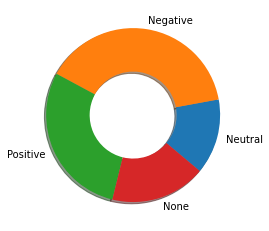

In [7]:
feels = ['Neutral', 'Negative', 'Positive', 'None']
arr = []
for i in feelings:
    arr.append(len(data[data['sentiment'] == i]))
plt.pie(arr, shadow = True, labels = feels, wedgeprops=dict(width=0.5), startangle=-40)

In [8]:
distribution = pd.DataFrame(columns = ['sentiment', 'quantity'])
for i, j in enumerate(feels):
    distribution = distribution.append({'sentiment' : j, 'quantity' : len(data[data['sentiment'] == feelings[i]])}, ignore_index = True)
distribution

,sentiment,quantity
0,Neutral,672
1,Negative,1884
2,Positive,1393
3,None,851


Most of the tweets in the dataset are labeled as Negative, actually slighly more than the half of the dataset with 1884 datapoints. The second most labeled sentiment was Positive with 1393. and None and Neutral are far more less with 851 and 672 datapoints respectively.

Deleting the tweets

## Language distribution

In [9]:
languages = data['lang'].unique()
print(languages)

['es']


In [10]:
len(data[data['lang'] == 'es'])

4800

All data points in the dataset are in spanish

## Dataset completeness

In [11]:
len(data[data['content'] == ''])

0

There are not empty values in the 'content' column, so all the data points contain  something in the tweet body.

## Length of the tweets

Let's insert the lengths of all tweet bodies in a new column named 'length'

In [12]:
# insert lengths column
lengths = []
for j in data['content']:
    lengths.append(len(j))

data.insert(loc = 0, value = lengths, column = 'length')
data

,length,user,content,date,lang,sentiment
767817507897872385,120,71463624,— ¿Nivel de inglés? — Alto. — Traduzca juguete...,Mon Aug 22 20:15:33 +0000 2016,es,NEU
772486813948575745,136,572924309,Si soy de área 4 y con suerte pase mate IV y m...,Sun Sep 04 17:29:43 +0000 2016,es,N
771871884451295233,133,158142748,Sabían que su after fav Teatro G. fue construi...,Sat Sep 03 00:46:12 +0000 2016,es,P
771947976302456832,134,132254421,Y hoy por primera vez me salí con el permiso d...,Sat Sep 03 05:48:34 +0000 2016,es,P
774741645484896256,132,105530236,"¿Para qué hacen coraje con Ambriz?, al final n...",Sat Sep 10 22:49:36 +0000 2016,es,N
...,...,...,...,...,...,...
811436261059792896,45,2227486286,@AmorAKilates @Roocio_Mk si me pasa lo mismo!,Wed Dec 21 05:00:55 +0000 2016,es,NONE
809280785182322688,49,140260506,@clauchoarrionda pquno ladra y ls demas retwitean,Thu Dec 15 06:15:49 +0000 2016,es,NEU
810772298911350784,71,3291225459,A mi desayuno le hizo falta un alfajor podrida...,Mon Dec 19 09:02:34 +0000 2016,es,N
813200690894045184,77,2257050336,Viste cuando necesitas que alguien te escuche ...,Mon Dec 26 01:52:07 +0000 2016,es,N


The next step is to detect the shortest and the longest tweets.

In [13]:
data.loc[data['length'] == min(data['length'])]

,length,user,content,date,lang,sentiment
777637901777514497,18,537526167,Me cago en la puta,Sun Sep 18 22:38:18 +0000 2016,es,N


In [14]:
data.loc[data['length'] == max(data['length'])]

,length,user,content,date,lang,sentiment
773545957191540736,139,737240617290457088,"No estoy aburrida -Estás aburrida - No -Si, r...",Wed Sep 07 15:38:22 +0000 2016,es,N


There is one shortest tweet body with 18 characters and the longest tweet body with 139 characters.

In [15]:
round(np.mean(data['length']))

89

The mean length of the tweet dataset is 89 characters.

## Content column data type

The 'content' column of the data frame conains the weet text of each data point so it is important to understand if the texts are in a type we can manipulate easily.

In [16]:
len(data.loc[data['content'].map(type) == str])

4800

All values in the 'content' column are string-type. So no more further type changes are necessary in the pre-processing phase.

## Word analysis

The next section will process words in the text of all the tweet bodies in the dataset to understand most used words.
First a tokenization and cleaning of the text is required.

#### Functions

In [17]:
nlp = spacy.load('es_dep_news_trf')

# Returns a list of lemmatized words using wordNetLemmatizer
def lemmatization(words):
    lemwn = WordNetLemmatizer()
    return [lemwn.lemmatize(x) for x in words]

# Returns a stemmed text.
def stemming(words):
    spanish_stemmer = SnowballStemmer('spanish')
    return spanish_stemmer.stem(words)

# Normalizing everything
def normalizer (data):
    #print(data)
    text = []
    tknz = TweetTokenizer(strip_handles = True, reduce_len = True)
    
    # Tokenization by word
    for j in data:
        new_token = tknz.tokenize(j)
        for k in new_token:
            text.append(k)
    #print(new_token)
    # Eliminates punctuation symbols
    #x = re.compile('[%s]' % re.escape(string.punctuation))
    nptext = []
    for token in text:
            new_token = re.sub("[^\w\s]", '', token)
            new_token = re.sub('^(?=[MDCLXVI])M*(C[MD]|D?C*)(X[CL]|L?X*)(I[XV]|V?I*)$', '', new_token)
            new_token = new_token.lower()
            new_token = re.sub('(?:^|\W)ja(?:$|\W)', 'XD', new_token)
            new_token = re.sub('(?:^|\W)jaja(?:$|\W)', 'XD', new_token)
            new_token = re.sub('(?:^|\W)jajaja(?:$|\W)', 'XD', new_token)
            new_token = re.sub('(?:^|\W)jajajaja(?:$|\W)', 'XD', new_token)
            new_token = re.sub('(?:^|\W)jajajajaja(?:$|\W)', 'XD', new_token)
            new_token = re.sub('(?:^|\W)jajajajajajaja(?:$|\W)', 'XD', new_token)
            new_token = re.sub('(?:^|\W)jajajajajajajaja(?:$|\W)', 'XD', new_token)
            new_token = re.sub('(?:^|\W)jajajajajajajajaja(?:$|\W)', 'XD', new_token)
            new_token = re.sub('(?:^|\W)ji(?:$|\W)', 'XD', new_token)
            new_token = re.sub('(?:^|\W)jiji(?:$|\W)', 'XD', new_token)
            new_token = re.sub('(?:^|\W)jijiji(?:$|\W)', 'XD', new_token)
            new_token = re.sub('(?:^|\W)jijijiji(?:$|\W)', 'XD', new_token)
            new_token = re.sub('(?:^|\W)jijijijiji(?:$|\W)', 'XD', new_token)
            new_token = re.sub('(?:^|\W)jijijijijijiji(?:$|\W)', 'XD', new_token)
            new_token = re.sub('(?:^|\W)jijijijijijijiji(?:$|\W)', 'XD', new_token)
            new_token = re.sub('(?:^|\W)jijijijijijijijiji(?:$|\W)', 'XD', new_token)
            if not new_token == '':
                nptext.append(new_token)
    # Eliminates numbers  
    nntext = [x for x in nptext if not x.isnumeric()]
    
    # Eliminates stop words
    stops = set(stopwords.words('spanish')) #are all lower case

    normtext = [token for token in nntext if token not in stops]
    
    # De-tokenize the list and puts everything into a string.
    string = ''
    string = ' '.join(normtext)
    # lemmatization
    lemtext = []
    for i, token in enumerate(nlp(string)):
        lemtext.append(token.lemma_)
    
    #print(lemtext)
    return lemtext


In [18]:
## Creating FreqDist for whole BoW, keeping the 20 most common tokens
def freqdist (normtext):
    all_fdist = FreqDist(normtext).most_common(20)

    #print(FreqDist(normtext).items())
    return all_fdist

In [19]:
def freqplot (all_fdist):
    ## Conversion to Pandas series via Python Dictionary for easier plotting
    all_fdist = pd.Series(dict(all_fdist))

    ## Setting figure, ax into variables
    fig, ax = plt.subplots(figsize=(10,10))

    ## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
    all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
    plt.xticks(rotation=30);
    plt.show()

### Unfiltered words

In [20]:
u_norm = normalizer(data['content'])

['nivel', 'inglés', 'alto', 'traduzca', 'juguete', 'toy', 'u él él', 'oración', 'toy', 'triste', 'awww', 'vengache', 'pa', 'acá', 'si', 'área', 'suerte', 'pase', 'mate', 'mate', 'poner', 'profe', 'qlero', 'mega', 'difícil', 'pasar', 'último', 'año', 'saber', 'after', 'fav', 'teatro', 'g', 'construido', 'día', 'hoy', 'ir', 'dar', 'placer', 'vean', 'ahí', 'metido', 'hoy', 'primero', 'vez', 'salir', 'permiso', 'mujer', 'detalle', 'si', 'saber', 'q', 'lado', 'q', 'llegar', 'casa', 'hacer', 'coraje', 'ambriz', 'final', 'ir', 'correr', 'salir', 'típico', 'frase', 'culpa', 'jugadores', 'mamá', 'nunca', 'dejar', 'disfrutar', 'juventud', 'mamá', 'felipe', 'llegar', 'borracho', 'año', 'ayñ', 'mamá', 'poder', 'dormir', 'despertar', 'madrugada', 'volver', 'recurrente', 'padre', 'así', 'arrimar', 'gustar', 'entrepierna', 'amor', 'guarda', 'pepino', 'pene', 'tanto', 'grande', 'ay', 'lejos', 'lejos', 'lejos', 'manejar', 'acá', 'padre', 'diferente', 'q', 'mal', 'q', 'feria', 'caballo', 'pq', 'si', 'qu

In [21]:
len(u_norm)

37150

In [22]:
print(u_norm)

['nivel', 'inglés', 'alto', 'traduzca', 'juguete', 'toy', 'u él él', 'oración', 'toy', 'triste', 'awww', 'vengache', 'pa', 'acá', 'si', 'área', 'suerte', 'pase', 'mate', 'mate', 'poner', 'profe', 'qlero', 'mega', 'difícil', 'pasar', 'último', 'año', 'saber', 'after', 'fav', 'teatro', 'g', 'construido', 'día', 'hoy', 'ir', 'dar', 'placer', 'vean', 'ahí', 'metido', 'hoy', 'primero', 'vez', 'salir', 'permiso', 'mujer', 'detalle', 'si', 'saber', 'q', 'lado', 'q', 'llegar', 'casa', 'hacer', 'coraje', 'ambriz', 'final', 'ir', 'correr', 'salir', 'típico', 'frase', 'culpa', 'jugadores', 'mamá', 'nunca', 'dejar', 'disfrutar', 'juventud', 'mamá', 'felipe', 'llegar', 'borracho', 'año', 'ayñ', 'mamá', 'poder', 'dormir', 'despertar', 'madrugada', 'volver', 'recurrente', 'padre', 'así', 'arrimar', 'gustar', 'entrepierna', 'amor', 'guarda', 'pepino', 'pene', 'tanto', 'grande', 'ay', 'lejos', 'lejos', 'lejos', 'manejar', 'acá', 'padre', 'diferente', 'q', 'mal', 'q', 'feria', 'caballo', 'pq', 'si', 'qu

There are 37771 words in the word list. The next step is to check for the frequency of each remaining word.

## All words

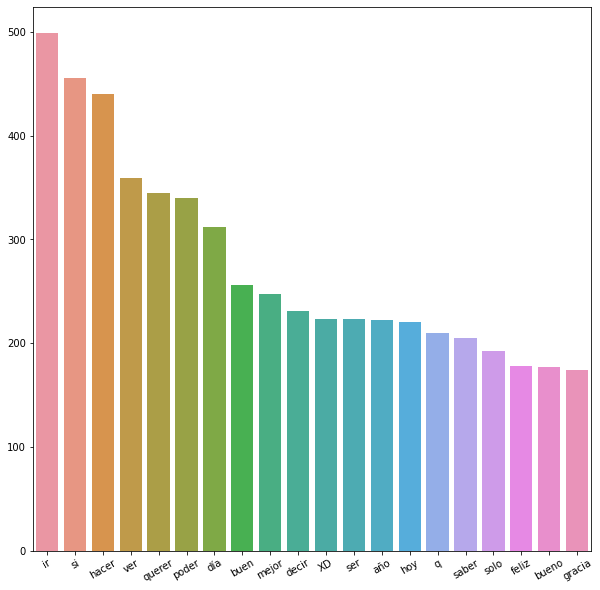

In [23]:
u_fdist = freqdist(u_norm)
freqplot(u_fdist)

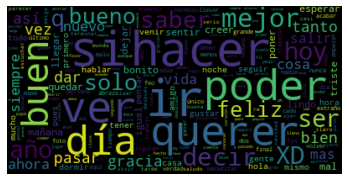

In [24]:
u_fdist = FreqDist(u_norm)
cloud = WordCloud().generate_from_frequencies(u_fdist, 60)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Positive words

In [25]:
p_norm = normalizer(data.loc[data['sentiment'] == 'P', ['content']].squeeze())

['saber', 'after', 'fav', 'teatro', 'g', 'construido', 'día', 'hoy', 'ir', 'dar', 'placer', 'vean', 'ahí', 'metido', 'hoy', 'primero', 'vez', 'salir', 'permiso', 'mujer', 'detalle', 'si', 'saber', 'q', 'lado', 'q', 'llegar', 'casa', 'buen', 'dia', 'elegir', 'q', 'cada', 'dia', 'milagro', 'dia', 'lleno', 'armonia', 'luz', 'amor', 'buena', 'vibra', 'elegir', 'ser', 'feliz', 'dios', 'sorprendido', 'semana', 'caja', 'cafe', 'cosas', 'tesi', 'venir', 'cosa', 'mejor', 'sige', 'maestría', 'XD', 'listo', 'fin', 'casa', 'dormir', 'hora', 'nomás', 'gracia', 'dios', 'papás', 'bien', 'ir', 'chingón', 'ahora', 'chingar él', 'salu', 'niñ', 'junto', 'jugar', 'preguntar él', 'hacer', 'saber', 'respuesta', 'correcto', 'mal', 'mal', 'falta', 'acabar yo', 'just', 'cause', 'si', 'jugar', 'mamada', 'yirs', 'fifa', 'papi', 'ojalá', 'just', 'cause', 'xbox', 'uju', 'temprano', 'hora', 'noche', 'sólo', 'faltar', 'leer', 'mensaje', 'whats', 'chido', 'gustar', 'leer', 'verdad', 'n', 'n', 'gracias', 'tú', 'verdad

In [26]:
len(p_norm)

10816

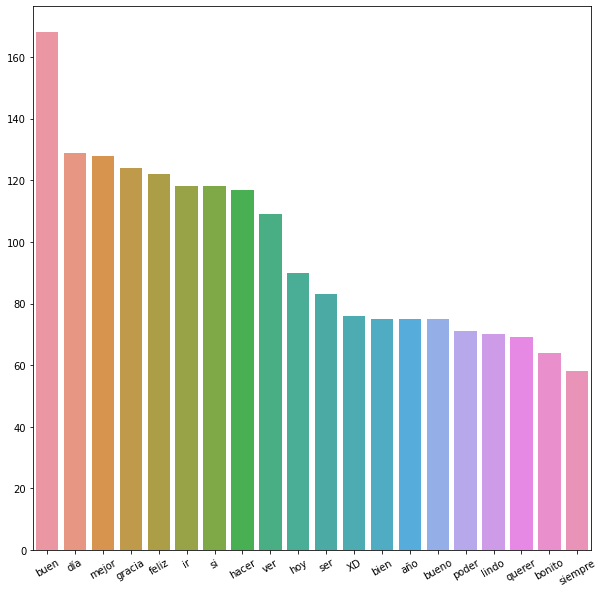

In [27]:
p_fdist = freqdist(p_norm)
freqplot(p_fdist)

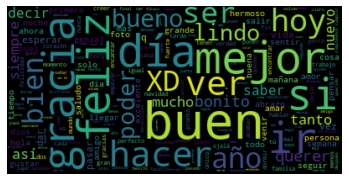

In [28]:
p_fdist = FreqDist(p_norm)
cloud = WordCloud().generate_from_frequencies(p_fdist, 60)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Negative words

In [29]:
n_norm = normalizer(data.loc[data['sentiment'] == 'N', ['content']].squeeze())

['si', 'área', 'suerte', 'pase', 'mate', 'mate', 'poner', 'profe', 'qlero', 'mega', 'difícil', 'pasar', 'último', 'año', 'hacer', 'coraje', 'ambriz', 'final', 'ir', 'correr', 'salir', 'típico', 'frase', 'culpa', 'jugadores', 'mamá', 'nunca', 'dejar', 'disfrutar', 'juventud', 'mamá', 'felipe', 'llegar', 'borracho', 'año', 'ayñ', 'mamá', 'poder', 'dormir', 'despertar', 'madrugada', 'volver', 'recurrente', 'padre', 'así', 'arrimar', 'gustar', 'entrepierna', 'amor', 'guarda', 'pepino', 'pene', 'tanto', 'grande', 'ay', 'ver', 'cuanto', 'akatsukis', 'salir', 'gaara', 'imbécil', 'sasuke', 'primero', 'episiodio', 'vida', 'eterno', 'dilema', 'mejor', 'dormir', 'mañana', 'terminar', 'ingue', 'voa', 'desvelar', 'morir', 'acabar', 'vez', 'ir', 'ir', 'dash', 'cortado', 'color', 'piel', 'color', 'langosta', 'hora', 'soñar', 'día', 'permitir', 'cómo', 'ir', 'ver', 'sputnik', 'tampoco', 'ir', 'ir', 'aguascalientes', 'rebel', 'tocar', 'little', 'va', 'ex', 'boletos', 'wwe', 'medallas', 'oro', 'phelps',

In [30]:
len(n_norm)

14696

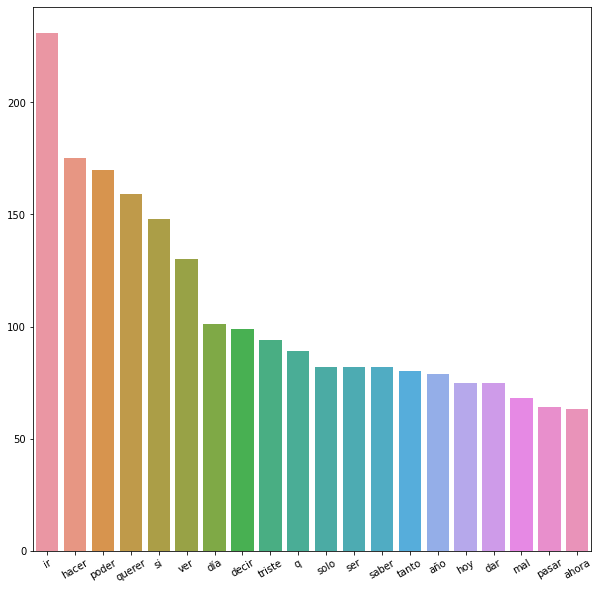

In [31]:
n_fdist = freqdist(n_norm)
freqplot(n_fdist)

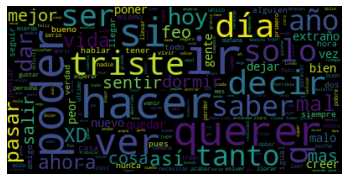

In [32]:
n_fdist = FreqDist(n_norm)
cloud = WordCloud().generate_from_frequencies(n_fdist, 60)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Neutral words

In [33]:
neu_norm = normalizer(data.loc[data['sentiment'] == 'NEU', ['content']].squeeze())

['nivel', 'inglés', 'alto', 'traduzca', 'juguete', 'toy', 'u él él', 'oración', 'toy', 'triste', 'awww', 'vengache', 'pa', 'acá', 'lejos', 'lejos', 'lejos', 'manejar', 'acá', 'padre', 'diferente', 'q', 'mal', 'q', 'feria', 'caballo', 'pq', 'si', 'quedar', 'XD', 'persona', 'decir', 'julio', 'sera', 'fin', 'saber', 'acercar', 'dos', 'fin', 'fin', 'mes', 'fin', 'semana', 'buen', 'día', 'bueno', 'después', 'dos', 'mes', 'fin', 'domingo', 'libre', 'disfrutar', 'malo', 'falte', 'hospital', 'resaca', 'volver', 'hacer', 'oye', 'aventamos', 'palitos', 'hilo', 'oye', 'años', 'na', 'mas', 'tigre', 'distinción', 'erectil', 'gustar', 'pasado', 'carlos', 'roberto', 'largo', 'lista', 'amigo', 'gente', 'creer', 'revuelco', 'ñoña', 'islarevancha', 'ferka', 'tony', 'ivonne', 'rafa', 'delia', 'ud', 'votos', 'vs', 'delia', 'siempre', 'ir', 'fuerte', 'saber', 'ver', 'este', 'contar', 'modelo', 'pasear', 'desnudo', 'si', 'pensar', 'primero', 'vez', 'todo', 'nervioso', 'hola', 'lvl', 'regalar', 'noska', '1er

In [34]:
len(neu_norm)

5425

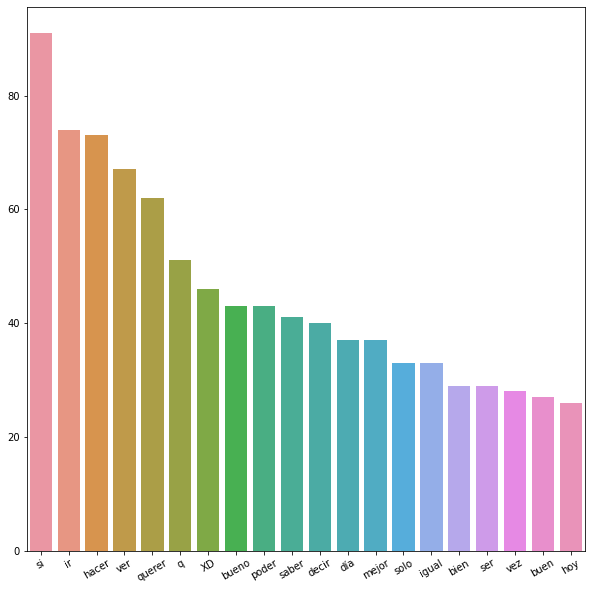

In [35]:
neu_fdist = freqdist(neu_norm)
freqplot(neu_fdist)

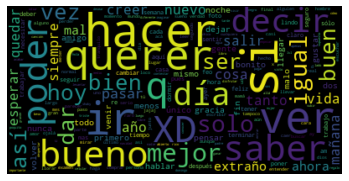

In [36]:
neu_fdist = FreqDist(neu_norm)
cloud = WordCloud().generate_from_frequencies(neu_fdist, 60)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()